# Preparing Data 4 the AE

### Import modules and Files

In [26]:
import pandas as pd
import numpy as np
import timeit, math, os, copy, yaml, ast
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit

from plot_functions import *
#%load_ext memory_profiler

In [27]:
me = "hRHGlobalm3"
monitoring_elements = pd.read_parquet(me+'_files_p1.parquet')

In [28]:
#removing from dataset instances corresponding to zero inst luminosity
monitoring_elements = monitoring_elements[monitoring_elements["mean_lumi"] > 2]

In [29]:
#normalising to lumi/1000 to get entries * pb-1s-1 as unit
monitoring_elements["data_norm"] = monitoring_elements["data"]/(0.001*monitoring_elements["mean_lumi"])
monitoring_elements["entries_norm"] = monitoring_elements["entries"]/(0.001*monitoring_elements["mean_lumi"])

### Occupancy Plots

#### Occupancy vs Lumi

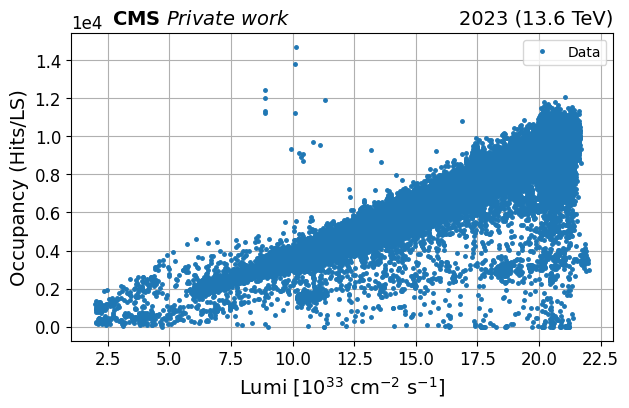

In [30]:
Show1Dimg(monitoring_elements['mean_lumi'], monitoring_elements['entries'])

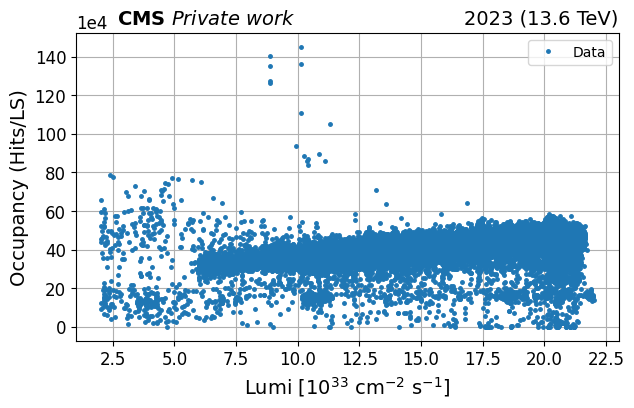

In [31]:
Show1Dimg(monitoring_elements['mean_lumi'], monitoring_elements['entries_norm'])

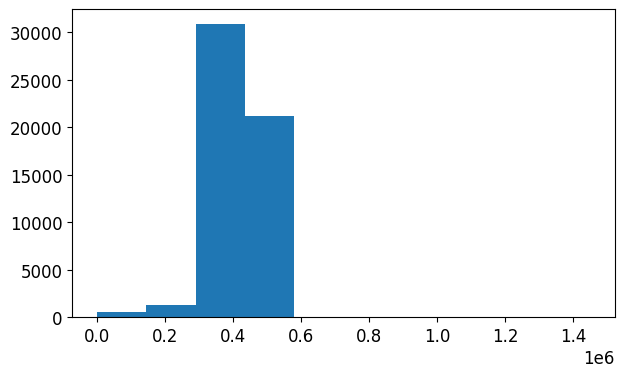

In [32]:
plt.figure(figsize=(7, 4))
plt.hist(monitoring_elements['entries_norm'] )
plt.show()

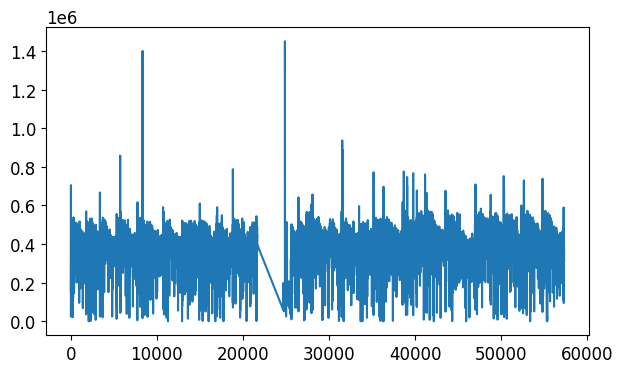

In [33]:
plt.figure(figsize=(7, 4))
plt.plot(monitoring_elements['entries_norm'])
plt.show()

In [34]:
mean_entries_norm = np.mean(monitoring_elements['entries_norm'])
std_entries_norm = np.std(monitoring_elements['entries_norm'])
up = mean_entries_norm+1*std_entries_norm
down = mean_entries_norm-1*std_entries_norm

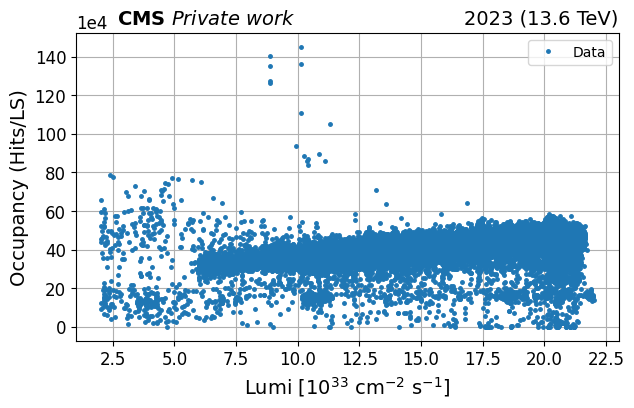

In [35]:
#remove outliers
monitoring_elements = monitoring_elements[((monitoring_elements["entries_norm"] > down) | (monitoring_elements["entries_norm"] < up) )]
Show1Dimg(monitoring_elements['mean_lumi'], monitoring_elements['entries_norm'])

In [36]:
monitoring_elements = monitoring_elements.sort_values(by=['run_number', 'ls_number']).reset_index()

In [37]:
monitoring_elements = monitoring_elements.reset_index()

### Sum over LS

Mean lumi: 2.181817071533


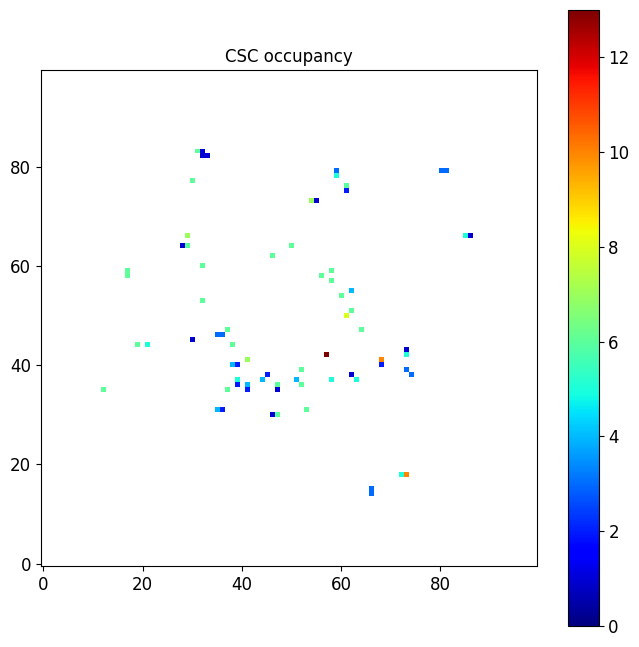

Mean lumi: 20.068316992187498


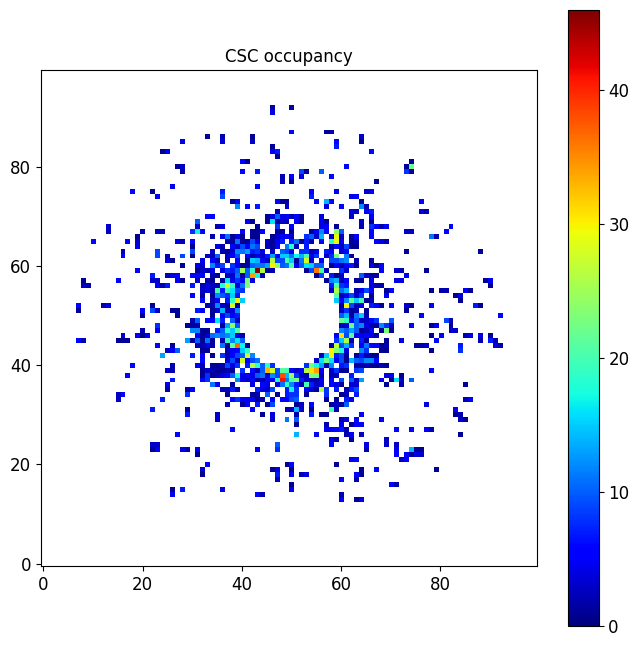

In [39]:
print("Mean lumi:", monitoring_elements["mean_lumi"][0])
img = Make_img(monitoring_elements['data'][0], monitoring_elements['x_bin'][0], monitoring_elements['x_min'][0], monitoring_elements['x_max'][0], monitoring_elements['y_bin'][0], monitoring_elements['y_min'][0], monitoring_elements['y_max'][0])
Show2Dimg(img)
print("Mean lumi:", monitoring_elements["mean_lumi"][2000])
img = Make_img(monitoring_elements['data'][2000], monitoring_elements['x_bin'][0], monitoring_elements['x_min'][0], monitoring_elements['x_max'][0], monitoring_elements['y_bin'][0], monitoring_elements['y_min'][0], monitoring_elements['y_max'][0])
Show2Dimg(img)

In [40]:
def XY_to_Polar(img):
    imgpolar = np.zeros((34, round(8*(2*math.pi))), dtype=np.float32)
    center = (49.5, 49.5)
    for i in range(100):
        for j in range(100):
            if(img[i,j]!=0):
                dist = np.sqrt((i-center[0])**2+(j-center[1])**2) -11
                theta = np.arctan2((j-center[1]), (i-center[0]))
                theta = theta + math.pi
                try:
                    if round(theta*8) == round(8*(2*math.pi)):
                        imgpolar[round(dist), 0] += img[i,j]
                    else:
                        imgpolar[round(dist), round(theta*8)] += img[i,j]
                except:
                    pass
    imgpolar[33,:]=0
    return imgpolar

In [51]:
def hadd_img(df, lumi_threshold):
    count = 0
    summed_img = []
    summed_lumi = []
    summed_entries = []
    summed_number = []
    run_min = []
    run_max = []
    lumi_min = []
    lumi_max = []
    dfs = []
    count = 0
    for it in range(len(df)):
        new_row = {'data_norm': df['data_norm'][it], 'lumi': df['mean_lumi'][it], 'entries_norm': df['entries_norm'][it]}
        if count == 0:
            run_min.append(df['run_number'][it])
            lumi_min.append(df['ls_number'][it])
        dfs.append(new_row)
        count +=1
        df_temp = pd.DataFrame(dfs)
        sumlumi = sum(df_temp['lumi'])
        if sumlumi >lumi_threshold: #to be divided by 1000 to get pb-1/s
            run_max.append(df['run_number'][it])
            lumi_max.append(df['ls_number'][it])
            sumdata = sum(df_temp['data_norm'])
            summed_img.append(XY_to_Polar(Make_img(sumdata, df['x_bin'][0], df['x_min'][0], df['x_max'][0], df['y_bin'][0], df['y_min'][0], df['y_max'][0])))
            #summed_img.append(Make_img(sumdata, df['x_bin'][0], df['x_min'][0], df['x_max'][0], df['y_bin'][0], df['y_min'][0], df['y_max'][0]))
            summed_lumi.append(sumlumi)
            summed_entries.append(sum(df_temp['entries_norm']))
            summed_number.append(count)
            count = 0
            dfs = []
            del sumdata
        del df_temp
        del sumlumi
        del new_row
    print("Total imgs: ",len(summed_img))
    return summed_img, summed_lumi, summed_entries, summed_number, run_min, run_max, lumi_min, lumi_max


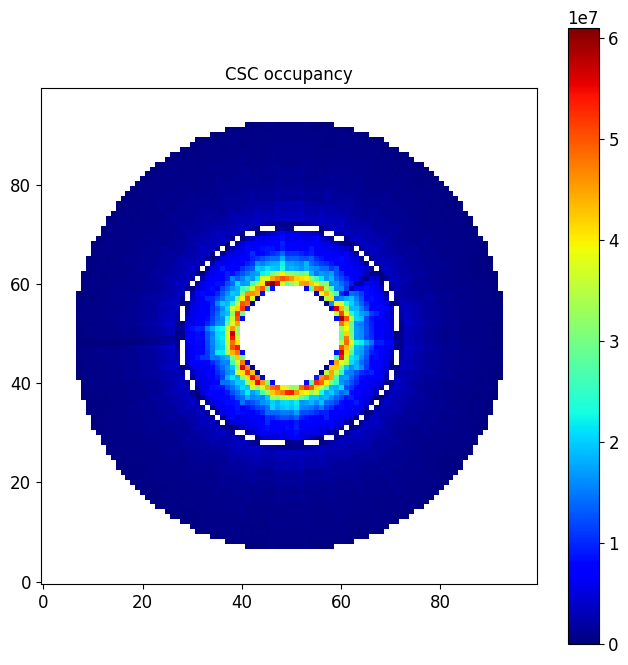

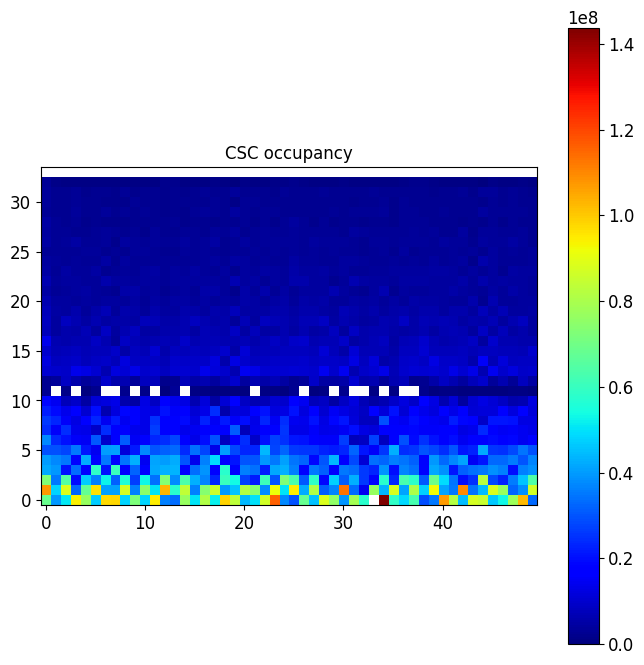

In [52]:
#have a look to the total (summed) distribution
sum_img = Make_img(sum(monitoring_elements['data_norm']), monitoring_elements['x_bin'][0], monitoring_elements['x_min'][0], monitoring_elements['x_max'][0], monitoring_elements['y_bin'][0], monitoring_elements['y_min'][0], monitoring_elements['y_max'][0])
Show2Dimg(sum_img)
Show2Dimg(XY_to_Polar(sum_img))

In [53]:
#hadding consecutive ls to get a given total lumi
imgs, lumis, entry, num, run_min, run_max, lumi_min, lumi_max = hadd_img(monitoring_elements, 300) #corresponds to 0.3 pb-1/s

Total imgs:  887


In [54]:
if len(run_min)>len(run_max):
    run_min.pop()
    lumi_min.pop()    

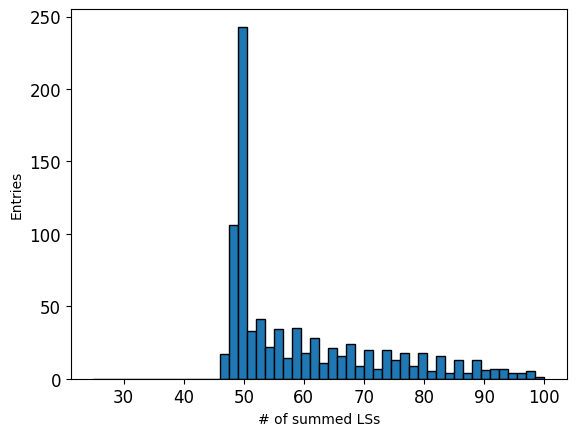

In [55]:
#this plot tells you how many consequent ls were summed up
plt.hist(num, bins=50, range=(25, 100), edgecolor='black')
plt.xlabel('# of summed LSs')
plt.ylabel('Entries')
plt.show()

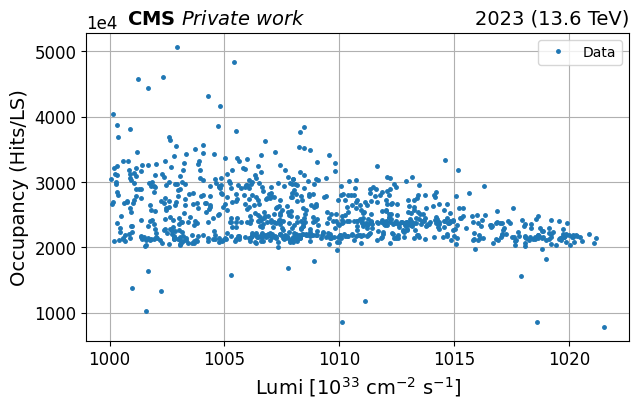

In [56]:
Show1Dimg(lumis, entry)

In [57]:
np.savez(me+'_files.npz', imgs=imgs, lumis=lumis, entry=entry, num=num, run_min=run_min, run_max=run_max, lumi_min=lumi_min, lumi_max=lumi_max)

### rebinning the upper rectangle

In [58]:
#Function definition
from scipy import signal
def rebin_rect(rect, nrows):
    #nrows is the number of rows to be summed together
    
    #if the rectangle cannot be equally divided into groups of nrows,
    #the last group will have n_last rows
    
    n_groups = rect.shape[0]//nrows
    n_last = rect.shape[0] % nrows
    
    main_kernel = np.ones((nrows, 1))
    final_kernel = np.ones((n_last,1))
    
    #main_rects[i] are the groups of nrows
    if n_last != 0:
        rebinned_rect = np.zeros((n_groups+1,rect.shape[1]))
        main_rects = rect[:-n_last].reshape(n_groups, nrows, rect.shape[1])
    else:
        rebinned_rect = np.zeros((n_groups,rect.shape[1]))
        main_rects = rect.reshape(n_groups, nrows, rect.shape[1])
    
    #summing for the well-divided groups
    for i in range(0,n_groups):
        rebinned_rect[i] = signal.convolve2d(main_rects[i], main_kernel, mode='valid')
        
    #summing for last group, if present
    if n_last != 0:
        rebinned_rect[-1] = signal.convolve2d(rect[-n_last:],final_kernel,mode='valid')
        
    return rebinned_rect
    
def rebin_whole(rect,upper_row, nrows_upper, nrows_lower):
    upper_rect = rect[upper_row:,]
    lower_rect = rect[:upper_row,]
    rebinned_upper = rebin_rect(upper_rect,nrows_upper)
    rebinned_lower = rebin_rect(lower_rect,nrows_lower)
    
    combined_rect = np.vstack((rebinned_lower, rebinned_upper))
    return combined_rect

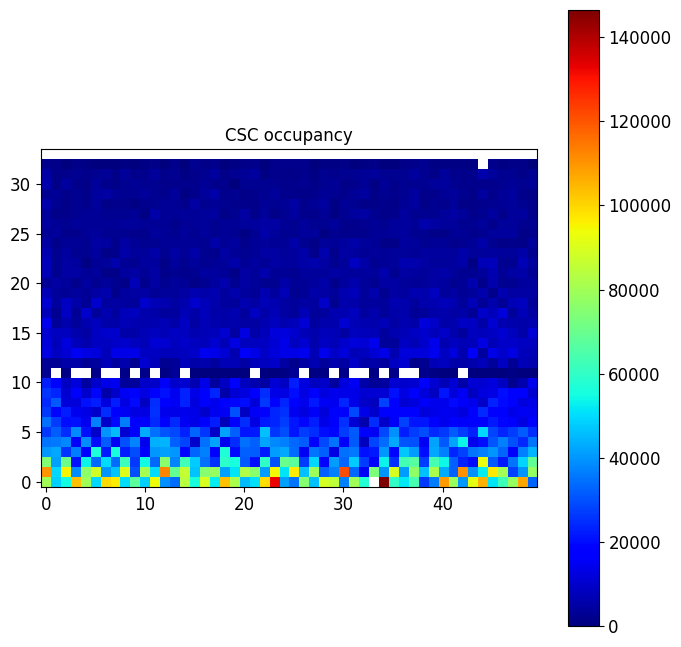

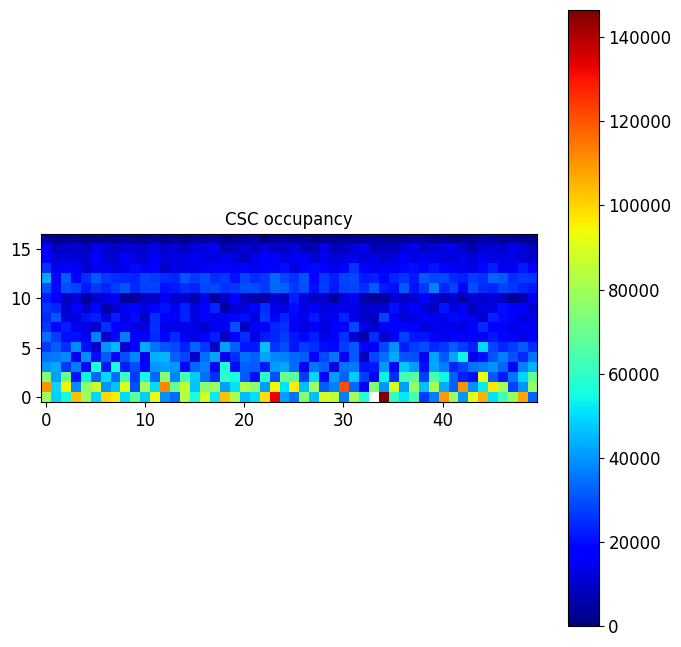

In [60]:
#random example of before - after compression
myImg = imgs[35]
Show2Dimg(myImg)
Show2Dimg(rebin_whole(myImg,11,4,1))

In [61]:
#save to new file
compressed_imgs = [rebin_whole(img,11,4,1) for img in imgs]
np.savez(me+'_files_compressed.npz', imgs=compressed_imgs, lumis=lumis, entry=entry, num=num)